# ReadMe:
    
This was the initial notebook I used to build up the functions and classes needed to create a text analysis web app. Run the FlaskApp.Py file for the app itself. 

# Part 1 : Import All Dependencies & Libraries Etc

In [1]:
#For data cleaning and visualization
import pandas as pd
import numpy as np
from numpy import save
from numpy import load
import matplotlib.pyplot as plt
from collections import Counter

#For web scraping
from bs4 import BeautifulSoup
import urllib.request
from urllib.request import Request, urlopen
from htmldate import find_date

#For Text Analysis
import textstat
textstat.set_lang("en")

#For NLP
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import *

from textblob import TextBlob
from textblob import Word

#For Random Forest Regressions For Personality Prediction
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

#For Similarity Between Docs
from gensim.models import doc2vec
from gensim.models.doc2vec import Doc2Vec

from scipy import spatial

#Other Misc
import random
import pickle
from tqdm.notebook import tqdm
import openpyxl
from math import pi
import datetime

In [2]:
#Load Trained Models for MTBI Classification
#Credit to authors of the pre-trained classifiers here
#https://github.com/wiredtoserve/datascience/tree/master/PersonalityDetection

dummy_fn = lambda x:x

with open('./MTBIModels/cv.pickle', 'rb') as f:
    cv = pickle.load(f)
    
with open('./MTBIModels/idf_transformer.pickle', 'rb') as f:
    idf_transformer = pickle.load(f)
    
# loading the pickle files with the classifiers
with open('./MTBIModels/LR_clf_IE_kaggle.pickle', 'rb') as f:
    lr_ie = pickle.load(f)
with open('./MTBIModels/LR_clf_JP_kaggle.pickle', 'rb') as f:
    lr_jp = pickle.load(f)
with open('./MTBIModels/LR_clf_NS_kaggle.pickle', 'rb') as f:
    lr_ns = pickle.load(f)
with open('./MTBIModels/LR_clf_TF_kaggle.pickle', 'rb') as f:
    lr_tf = pickle.load(f)



C:\Users\Lenovo\Anaconda3\envs\sentimentAnalysis\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Lenovo\Anaconda3\envs\sentimentAnalysis\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Lenovo\Anaconda3\envs\sentimentAnalysis\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, 

In [3]:
# Load Pre-Trained Models for Big5 OCEAN Personality Classification
# Credit to authors of the original pre-trained classifiers here https://github.com/jcl132/personality-prediction-from-text
# Note - the full project above does more than classify as it also extracts and classifies the FB profiles of your friends 
# and plots it on a web app- check it out yourself!

class Model(): # Note "Model" represents the Big 5 OCEAN Model. I can't rename as it seems to affect the pickled files
    def __init__(self):
        self.rfr = RandomForestRegressor(bootstrap=True,
         max_features='sqrt',
         min_samples_leaf=1,
         min_samples_split=2,
         n_estimators= 200)
        self.rfc = RandomForestClassifier(max_features='sqrt', n_estimators=110)
        self.tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

    def fit(self, X, y, regression=True):
        X = self.tfidf.fit_transform(X)
        if regression:
            self.rfr = self.rfr.fit(X, y)
        else:
            self.rfc = self.rfc.fit(X, y)

    def predict(self, X, regression=True):
        X = self.tfidf.transform(X)
        if regression:
            return self.rfr.predict(X)
        else:
            return self.rfc.predict(X)

    def predict_proba(self, X, regression=False):
        X = self.tfidf.transform(X)
        if regression:
            raise ValueError('Cannot predict probabilites of a regression!')
        else:
            return self.rfc.predict_proba(X)


traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
#### (O) Openess
#### (C) Conscientiousness
#### (E) Extraversion
#### (A) Agreeableness
#### (N) Neuroticism

model = Model()
models = {}    
for trait in traits:
    with open('BigFiveModels/' + trait + '_model.pkl', 'rb') as f:
        models[trait] = pickle.load(f)


In [4]:
#Load the Clap Prediction Model with the 'simple' Lasso Regression model - CAUTION - It is not very accurate ! 

with open("./ClapPredictionModels/clap_prediction_model_lasso.pkl", 'rb') as file:
    clap_prediction_model_lasso = pickle.load(file)

column_for_regression=["sentence_count","title_word_count","average_word_count_per_sentence",
                      "text_word_count","vocab_count_excl_commonwords","imgs_per_1000words",
                      "FS_GradeScore","vids_per_1000words","polarity","subjectivity"]


In [5]:
#Load the pre-trained Doc2Vec Model trained on 200 sample Medium Data Science articles with 300 vec dimensions

Doc2VecModel= Doc2Vec.load("./ClapPredictionModels/Doc2Vec.model")

#Load the average document vector for the 37 out of the 200 reference articles that have > 5k Claps  

VH_Vec=load('./ClapPredictionModels/VH_Claps_Vector.npy')
H_Vec=load('./ClapPredictionModels/H_Claps_Vector.npy')
M_Vec=load('./ClapPredictionModels/M_Claps_Vector.npy')
L_Vec=load('./ClapPredictionModels/L_Claps_Vector.npy')
VL_Vec=load('./ClapPredictionModels/VL_Claps_Vector.npy')


In [6]:
# A large unwieldy class I created that does everything from
# web scraping and cleaning the data , calculating the key metrics 
# and plotting key charts once a URL is provided
# Open to suggestions on how to simplify

class ArticleExtract():

    def __init__(self,url,text_input=False):
        self.url = url
        self.text_input= text_input
    
    #Set get_html and cleaned_text as properties as these get re-used by other functions
    @property
    def get_html(self):
        user_agent_list = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
                            'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
                            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
                            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
                            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
                        ]

        if self.text_input==False:
            for i in range(1,4):
                #Pick a random user agent
                user_agent = random.choice(user_agent_list)
                #Set the headers 
                headers = {'User-Agent': user_agent}

                req = Request(self.url, headers=headers)

                self._get_html = urlopen(req).read()

        if self.text_input==True:
                self._get_html = self.url
                
        return self._get_html
    
    @property
    def cleaned_text(self):
        self._cleaned_text=BeautifulSoup(self.get_html, "html.parser").get_text(" ").replace("\r", " ").replace("\t", " ").replace("\n", " ").replace(u'\xa0', u' ')
        return self._cleaned_text
    
    @property
    def tokens_alpha(self):
        raw = BeautifulSoup(self.get_html, 'html.parser').get_text(strip=True)
        words = nltk.word_tokenize(raw)
        self._tokens_alpha= [word for word in words if word.isalpha()] # or use option of := if word.isalnum()
        return self._tokens_alpha
    
    def extract_title(self):
        return BeautifulSoup(self.get_html).title.string
        
    def get_date(self):
        return find_date(self.url)
            
    def extract_tags(self):
        tags = []
        tags = [x.text for x in BeautifulSoup(self.get_html).find_all("a", href=re.compile(".*tag.*"))]
        if len(tags) == 0:
            return 'None'
        else:
            return tags

    def image_count(self):
        try:
            article_soup = BeautifulSoup(self.get_html).find('article')
            figures = article_soup.find_all('figure')
            if len(figures)>0:
                return len(figures)
            else:
                return len(BeautifulSoup(self.get_html).find_all('img'))
        except:
            return len(BeautifulSoup(self.get_html).find_all('img'))    

    def embedded_vids_count(self):
        return str(self.get_html).count("embed&display_name=YouTube")
               
    def other_embedded_items_count(self):
        return int(str(self.get_html).count("iframeSrc"))-int(self.embedded_vids_count())
    
    def word_count(self):
        return textstat.lexicon_count(self.cleaned_text, removepunct=True)
    
    def tokenize_excl_stopwords(self): #a bit of repetition but this version unlike the other tokenize text removes stop words
        lst= re.findall(r'\b\w+', self.cleaned_text)
        lst = [x.lower() for x in lst]
        counter = Counter(lst)
        occs = [(word,count) for word,count in counter.items() if count > 1]
        occs.sort(key=lambda x:x[1])
        WordListWithCommonWordsRemoved=[(occs[i][0],occs[i][1]) for i in range(len(occs)) if not occs[i][0] in stopwords.words()]
        return WordListWithCommonWordsRemoved
        
    def vocab_count_excl_commonwords(self):
        return len(self.tokenize_excl_stopwords())
    
    def most_common_words(self):
        return self.tokenize_excl_stopwords()[-5:]
    
    def sentence_count(self):
        blob = TextBlob(self.cleaned_text)
        split_text=blob.sentences
        No_Of_Sentences=len(split_text)
        #textstat.sentence_count(self.cleaned_text) #Initially used this but textstat tends to undercount
        return textstat.sentence_count(self.cleaned_text)
         
    def content_summary(self):
        blob = TextBlob(self.cleaned_text)
        split_text=blob.sentences

        nouns = list()
        for word, tag in blob.tags:
            if tag == 'NN':
                nouns.append(word.lemmatize())
        text_summary=["This text is about..."]
        
        for item in random.sample(nouns, 5):
            word = Word(item)
            if len(word)>3:
                text_summary.append(word) # Can also use word.pluralize()
        
        return text_summary

    def sentiment(self):
        blob = TextBlob(self.cleaned_text)
        split_text=blob.sentences
        df=pd.DataFrame((''.join(split_text[i]) for i in range(len(split_text))),columns=['Sentences'])
        df[["TextBlob_Polarity","TextBlob_Subjectivity"]]=pd.DataFrame((split_text[i].sentiment for i in range(len(split_text))))
        df=df[df['Sentences'].map(len) > 15] #Remove all short sentences
        #Avoid counting any sentences with Polarity 0 or Subjectivity 0 
        TextBlob_Overall_Polarity=df[df["TextBlob_Polarity"] != 0]['TextBlob_Polarity'].median()
        TextBlob_Overall_Subjectivity=df[df["TextBlob_Subjectivity"] != 0]['TextBlob_Subjectivity'].median()
        return TextBlob_Overall_Polarity,TextBlob_Overall_Subjectivity
       
    def polarity(self):
        return self.sentiment()[0]*100
    
    def subjectivity(self):
        return self.sentiment()[1]*100
       
    def common_trigrams(self):
        trigram_measures = nltk.collocations.TrigramAssocMeasures()
        finder = TrigramCollocationFinder.from_words(self.tokens_alpha)
        finder.apply_freq_filter(2)
        finder.nbest(trigram_measures.pmi, 5)  # doctest: +NORMALIZE_WHITESPACE
        FiveMostCommonlyOccuringTrigrams=finder.nbest(trigram_measures.pmi, 5)
        return FiveMostCommonlyOccuringTrigrams
        
    def FS_ReadingEaseScore(self):
        FS_GradeScore=textstat.flesch_reading_ease(self.cleaned_text)
        return FS_GradeScore
    
    def FS_ReadingEaseLevel(self):
        FS_GradeScore=textstat.flesch_reading_ease(self.cleaned_text)
        if FS_GradeScore >= 90:
            FS_Grade="Very easy to read"
        elif FS_GradeScore <90 and FS_GradeScore >=80:
            FS_Grade="Easy"
        elif FS_GradeScore <80 and FS_GradeScore >=70:
            FS_Grade="Fairly easy"
        elif FS_GradeScore <70 and FS_GradeScore >=60:
            FS_Grade="Standard"
        elif FS_GradeScore <60 and FS_GradeScore >=50:
            FS_Grade="Fairly Difficult"
        elif FS_GradeScore <50 and FS_GradeScore >=30:
            FS_Grade="Difficult"
        else :
            FS_Grade="Very Confusing"
        return FS_Grade    
    
    @property
    def MTBI_Analysis(self):           
        c = cv.transform([self.tokens_alpha])
        x = idf_transformer.transform(c)

        ie = lr_ie.predict_proba(x).flatten()
        ns = lr_ns.predict_proba(x).flatten()
        tf = lr_tf.predict_proba(x).flatten()
        jp = lr_jp.predict_proba(x).flatten()

        probs = np.vstack([ie, ns, tf, jp])

#         names = ["Introversion - Extroversion", "Intuiting - Sensing", "Thinking - Feeling", "Judging - Perceiving"]        
        
#         for i, dim in enumerate(names):
#             print(f"{dim:28s}: {probs[i,1]:.3f} - {probs[i, 0]:.3f}")

        Extraversion=probs[0][0]
        Introversion=probs[0][1]
        Sensing=probs[1][0]
        Intuiting=probs[1][1]
        Feeling=probs[2][0]
        Thinking=probs[2][1]
        Perceiving=probs[3][0]
        Judging=probs[3][1]

        if Introversion>=0.5:
            IE="I"
        else:
            IE="E"
        if Intuiting>=0.5:
            NS="N"
        else:
            NS="S"
        if Thinking>=0.5:
            TF="T"
        else:
            TF="F"
        if Judging>=0.5:
            JP="J"
        else:
            JP="P"
            
        self._MTBI_Results = [IE+NS+TF+JP, Introversion, Intuiting, Thinking, Judging]

        return self._MTBI_Results
        
    def plot_MTBI(self):
        c = cv.transform([self.tokens_alpha])
        x = idf_transformer.transform(c)

        ie = lr_ie.predict_proba(x).flatten()
        ns = lr_ns.predict_proba(x).flatten()
        tf = lr_tf.predict_proba(x).flatten()
        jp = lr_jp.predict_proba(x).flatten()
        
        probs = np.vstack([ie, ns, tf, jp])
        
        Extraversion=probs[0][0]
        Introversion=probs[0][1]
        Sensing=probs[1][0]
        Intuiting=probs[1][1]
        Feeling=probs[2][0]
        Thinking=probs[2][1]
        Perceiving=probs[3][0]
        Judging=probs[3][1]
        
        if Introversion>=0.5:
            IE="I"
        else:
            IE="E"
        if Intuiting>=0.5:
            NS="N"
        else:
            NS="S"
        if Thinking>=0.5:
            TF="T"
        else:
            TF="F"
        if Judging>=0.5:
            JP="J"
        else:
            JP="P"
        
        names = ["Introversion - Extroversion", "Intuiting - Sensing", "Thinking - Feeling", "Judging - Perceiving"]        

        print("Myers-Briggs Type Indicator: "+IE+NS+TF+JP)
        print("")    
        for i, dim in enumerate(names):
             print(f"{dim:28s}: {probs[i,1]:.3f} - {probs[i, 0]:.3f}")
                
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca() 
        xlabels = ["Judging (J)","Thinking (T)", "Intuiting (N)","Introversion (I)"]
        xlabels2 =["Perceiving (P)","Feeling (F)","Sensing (S)","Extraversion(E)"]
        ax.barh(xlabels, [1, 1, 1, 1])   
        ax.barh(xlabels, [Perceiving, Feeling, Sensing, Extraversion]) 
        ax.set_xlim([0, 1])
        ax.set_xlabel("Propensity")
        ax2 = ax.twinx()
        ax2.barh(xlabels2,[1, 1, 1, 1])
        ax2.barh(xlabels2, [Judging, Thinking, Intuiting, Introversion]) 
        return plt.show(fig)
                

    @property
    def OCEAN_Analysis(self):
        predictions = {}
        trait_list = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
        X=[self.cleaned_text]

        for trait in trait_list:
            pkl_model = models[trait]

            trait_scores = pkl_model.predict(X, regression=True).reshape(1, -1)

            predictions['pred_s'+trait] = trait_scores.flatten()[0]

            trait_categories = pkl_model.predict(X, regression=False)
            predictions['pred_c'+trait] = str(trait_categories[0])

            trait_categories_probs = pkl_model.predict_proba(X)
            predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1][0]
            self._OCEAN_Analysis = predictions
      
        return self._OCEAN_Analysis      
                  

    def plot_OCEAN_Radar(self):        
         # Set data

        listofval=["Sample",(self.OCEAN_Analysis).get('pred_sOPN'),(self.OCEAN_Analysis).get('pred_sCON'),(self.OCEAN_Analysis).get('pred_sEXT'),(self.OCEAN_Analysis).get('pred_sAGR'),(self.OCEAN_Analysis).get('pred_sNEU')]

        xdf = pd.DataFrame([listofval],columns=["Label","Openess","Conscientiousness","Extraversion","Agreeableness","Neuroticism"])

        # number of variable
        categories=list(xdf)[1:]
        N = len(categories)

            # We are going to plot the first line of the data frame.
            # But we need to repeat the first value to close the circular graph:
        values=xdf.loc[0].drop('Label').values.flatten().tolist()
        values += values[:1]
        values

            # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

            # Initialise the spider plot
        ax = plt.subplot(111, polar=True)

            # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories, color='grey', size=8)

            # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=7)
        plt.ylim(0,5)

            # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')

            # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)

        return plt.show()
    
    def sentence_by_sentence_analysis(self):
        blob = TextBlob(self.cleaned_text)
        split_text=blob.sentences
        df=pd.DataFrame((''.join(split_text[i]) for i in range(len(split_text))),columns=['Sentences'])
        df["Sentence Word Count"]= pd.DataFrame(len(df["Sentences"][i].split()) for i in range(len(df)))
        df["FS_GradeScore"] = pd.DataFrame((textstat.flesch_reading_ease(df["Sentences"][i]) for i in range(len(df))))
        df[["TextBlob_Polarity","TextBlob_Subjectivity"]]=round(pd.DataFrame((split_text[i].sentiment for i in range(len(split_text))))*100,1)
        return df
    
   
    def plot_sentence_by_sentence(self,type="polarity"):
        blob = TextBlob(self.cleaned_text)
        split_text=blob.sentences
        df=pd.DataFrame((''.join(split_text[i]) for i in range(len(split_text))),columns=['Sentences'])
        df["Sentence Word Count"]= pd.DataFrame(len(df["Sentences"][i].split()) for i in range(len(df)))
        df["FS_GradeScore"] = pd.DataFrame((textstat.flesch_reading_ease(df["Sentences"][i]) for i in range(len(df))))
        df[["TextBlob_Polarity","TextBlob_Subjectivity"]]=round(pd.DataFrame((split_text[i].sentiment for i in range(len(split_text))))*100,1)

        # gca stands for 'get current axis'
        ax = plt.gca()

        if type=="polarity":
            plotvar='TextBlob_Polarity'
        elif type=="subjectivity":
            plotvar='TextBlob_Subjectivity'
        elif type=="readability":
            plotvar="FS_GradeScore"
        elif type=="wordcount":
            plotvar="Sentence Word Count"
        else:
            plotvar="polarity"
        
        print("Plot Of ",plotvar," By Sentence")
        df.plot(kind='line',y=plotvar,ax=ax)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()

        # set the y-spine
        ax.spines['bottom'].set_position('zero')

        # turn off the top spine/ticks
        ax.spines['top'].set_color('none')
        ax.xaxis.tick_bottom()

        print("The X-Axis represents sentences within the document")
        return plt.show()
    
    
    def plot_subjectivity_by_sentence(self):
        blob = TextBlob(self.cleaned_text)
        split_text=blob.sentences
        df=pd.DataFrame((''.join(split_text[i]) for i in range(len(split_text))),columns=['Sentences'])
        df[["TextBlob_Polarity","TextBlob_Subjectivity"]]=round(pd.DataFrame((split_text[i].sentiment for i in range(len(split_text))))*100,1)

        # gca stands for 'get current axis'
        ax = plt.gca()

        df.plot(kind='line',y='TextBlob_Subjectivity', color='red', ax=ax)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()

        # set the y-spine
        ax.spines['bottom'].set_position('zero')

        # turn off the top spine/ticks
        ax.spines['top'].set_color('none')
        ax.xaxis.tick_bottom()

        print("The X-Axis represents sentences within the document")
        return plt.show()    
       
    def plot_readability_by_sentence(self):
        blob = TextBlob(self.cleaned_text)
        split_text=blob.sentences
        df=pd.DataFrame((''.join(split_text[i]) for i in range(len(split_text))),columns=['Sentences'])
        df["Sentence Word Count"]= pd.DataFrame(len(df["Sentences"][i].split()) for i in range(len(df)))
        df["FS_GradeScore"] = pd.DataFrame((textstat.flesch_reading_ease(df["Sentences"][i]) for i in range(len(df))))

        # gca stands for 'get current axis'
        ax = plt.gca()

        df.plot(kind='line',y='FS_GradeScore',color='blue',ax=ax)
        df.plot(kind='line',y='Sentence_Word_Count', color='black', ax=ax)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()

        # set the y-spine
        ax.spines['bottom'].set_position('zero')

        # turn off the top spine/ticks
        ax.spines['top'].set_color('none')
        ax.xaxis.tick_bottom()

        print("The X-Axis represents sentences within the document")
        return plt.show()       
       
    def summary(self):
        
        if self.text_input==False:
            
            summaryOfArticle = {
                "Analysis Type":"Extracted Web-Page",
                "title": self.extract_title(),
                "pub_date":self.get_date(),

                "url":self.url,
                #Semantic Content
                "tags": self.extract_tags(),
                "content_summary":self.content_summary(),
                "most_common_trigrams":self.common_trigrams(),

                #Lexical Content
                "title_word_count": (len(self.extract_title().replace(":","").replace("'","").replace("/","").split())),
                "text_word_count": self.word_count(),
                "vocab_count_excl_commonwords": self.vocab_count_excl_commonwords(),
                "most frequent words":self.most_common_words(),

                "sentence_count":self.sentence_count(),
                "average_word_count_per_sentence":self.word_count()/self.sentence_count(),

                #Readability
                "FS_GradeLevel":self.FS_ReadingEaseLevel(),
                "FS_GradeScore":self.FS_ReadingEaseScore(),

                #Metadata Metrics
                "image_count": self.image_count(),
                "embedded_vids_count": self.embedded_vids_count(),
                "other_embedded_items_count": self.other_embedded_items_count(),
                "imgs_per_1000words": ((self.image_count())/(self.word_count()))*1000,
                "vids_per_1000words": ((self.embedded_vids_count())/(self.word_count()))*1000,

                #Sentiment Analysis

                "polarity":self.polarity(),
                "subjectivity":self.subjectivity(),

                #Personality Analysis
                "MTBI_Type":self.MTBI_Analysis[0],
                "MTBI_Introversion":self.MTBI_Analysis[1],
                "MTBI_Extraversion":1-self.MTBI_Analysis[1],
                "MTBI_iNtuiting":self.MTBI_Analysis[2],
                "MTBI_Sensing":1-self.MTBI_Analysis[2], 
                "MTBI_Thinking":self.MTBI_Analysis[3],
                "MTBI_Feeling":1-self.MTBI_Analysis[3],
                "MTBI_Judging":self.MTBI_Analysis[4],
                "MTBI_Perceiving":1-self.MTBI_Analysis[4],

                "Big5_Openess":(self.OCEAN_Analysis).get('pred_sOPN'),
                "Big5_Conscientiousness":(self.OCEAN_Analysis).get('pred_sCON'),
                "Big5_Extraversion":(self.OCEAN_Analysis).get('pred_sEXT'),
                "Big5_Agreeableness":(self.OCEAN_Analysis).get('pred_sAGR') , 
                "Big5_Neuroticism": (self.OCEAN_Analysis).get('pred_sNEU')}

                #"raw_text":self.cleaned_text}
            
        elif self.text_input==True:
                
            summaryOfArticle = {
                "Analysis Type":"Freeform Text Entry",

                #Semantic Content
                "content_summary":self.content_summary(),
                "most_common_trigrams":self.common_trigrams(),

                #Lexical Content
                "text_word_count": self.word_count(),
                "vocab_count_excl_commonwords": self.vocab_count_excl_commonwords(),
                "most frequent words":self.most_common_words(),

                "sentence_count":self.sentence_count(),
                "average_word_count_per_sentence":self.word_count()/self.sentence_count(),

                #Readability
                "FS_GradeLevel":self.FS_ReadingEaseLevel(),
                "FS_GradeScore":self.FS_ReadingEaseScore(),

                #Sentiment Analysis

                "polarity":self.polarity(),
                "subjectivity":self.subjectivity(),

                #Personality Analysis
                "MTBI_Type":self.MTBI_Analysis[0],
                "MTBI_Introversion":self.MTBI_Analysis[1],
                "MTBI_Extraversion":1-self.MTBI_Analysis[1],
                "MTBI_iNtuiting":self.MTBI_Analysis[2],
                "MTBI_Sensing":1-self.MTBI_Analysis[2], 
                "MTBI_Thinking":self.MTBI_Analysis[3],
                "MTBI_Feeling":1-self.MTBI_Analysis[3],
                "MTBI_Judging":self.MTBI_Analysis[4],
                "MTBI_Perceiving":1-self.MTBI_Analysis[4],

                "Big5_Openess":(self.OCEAN_Analysis).get('pred_sOPN'),
                "Big5_Conscientiousness":(self.OCEAN_Analysis).get('pred_sCON'),
                "Big5_Extraversion":(self.OCEAN_Analysis).get('pred_sEXT'),
                "Big5_Agreeableness":(self.OCEAN_Analysis).get('pred_sAGR') , 
                "Big5_Neuroticism": (self.OCEAN_Analysis).get('pred_sNEU')}

                #"raw_text":self.cleaned_text}
        
        return summaryOfArticle


In [ ]:
# # Scrape and extract articles 
#url_list_w_claps=pd.read_csv('Medium_DataScienceArticlesBatch2.csv') 
#url_list=url_list_w_claps["url"].tolist()

# df=pd.DataFrame()
# i=0

# for url in tqdm(url_list):
#     SingleArticle=ArticleExtract(url)
#     SingleDictionary=SingleArticle.summary()
#     SingleRowDataFrame = pd.DataFrame.from_dict(SingleDictionary, orient='index', columns=[str(i)])
#     SingleRowDataFrame = SingleRowDataFrame.transpose()
#     df=df.append(SingleRowDataFrame)
#     i += 1

# df.to_excel('output.xlsx')

In [7]:
#Example Usage With String Text Input
FreeText='We choose to go to the moon. We choose to go to the moon in this decade and do the other things, not because they are easy, but because they are hard, because that goal will serve to organize and measure the best of our energies and skills, because that challenge is one that we are willing to accept, one we are unwilling to postpone, and one which we intend to win, and the others, too.'
FreeTextAnalysis=ArticleExtract(FreeText,text_input=True)
FreeTextAnalysis.summary()

{'Analysis Type': 'Freeform Text Entry',
 'content_summary': ['This text is about...',
  'challenge',
  'moon',
  'decade',
  'moon',
  'goal'],
 'most_common_trigrams': [('We', 'choose', 'to'),
  ('because', 'they', 'are'),
  ('choose', 'to', 'go'),
  ('go', 'to', 'the'),
  ('to', 'the', 'moon')],
 'text_word_count': 76,
 'vocab_count_excl_commonwords': 3,
 'most frequent words': [('choose', 2), ('go', 2), ('moon', 2)],
 'sentence_count': 2,
 'average_word_count_per_sentence': 38.0,
 'FS_GradeLevel': 'Standard',
 'FS_GradeScore': 66.75,
 'polarity': 34.444444444444436,
 'subjectivity': 53.333333333333336,
 'MTBI_Type': 'ENTJ',
 'MTBI_Introversion': 0.40530440136343615,
 'MTBI_Extraversion': 0.5946955986365638,
 'MTBI_iNtuiting': 0.8699037770598073,
 'MTBI_Sensing': 0.13009622294019274,
 'MTBI_Thinking': 0.7246304818805869,
 'MTBI_Feeling': 0.2753695181194131,
 'MTBI_Judging': 0.5050900258987898,
 'MTBI_Perceiving': 0.4949099741012102,
 'Big5_Openess': 3.9533448949705927,
 'Big5_Consci

In [9]:
#Example Usage Of Class With Web Page - Note default for text_input=False so just need to put in the url only
TestArticle=ArticleExtract('https://medium.com/analytics-vidhya/interesting-python-tips-and-tricks-6d033967b5a5')
SampleSummary=TestArticle.summary()

In [10]:
#Show Summary For Sample Web Page
SampleSummary

{'Analysis Type': 'Extracted Web-Page',
 'title': 'Interesting Python Tips and Tricks | by Ravi | Analytics Vidhya | Sep, 2020 | Medium',
 'pub_date': '2020-09-13',
 'url': 'https://medium.com/analytics-vidhya/interesting-python-tips-and-tricks-6d033967b5a5',
 'tags': ['Hackathon',
  'Programming',
  'Python',
  'Software Development',
  'Software Engineering',
  'Python Programming'],
 'content_summary': ['This text is about...',
  'tuple',
  'print',
  'list',
  'integer'],
 'most_common_trigrams': [('Alice', 'Bob', 'Charlie'),
  ('data', 'science', 'ecosystem'),
  ('science', 'ecosystem', 'https'),
  ('Data', 'Science', 'professionals'),
  ('Science', 'professionals', 'We')],
 'title_word_count': 16,
 'text_word_count': 1566,
 'vocab_count_excl_commonwords': 163,
 'most frequent words': [('2', 30),
  ('b', 30),
  ('0', 35),
  ('1', 39),
  ('print', 58)],
 'sentence_count': 29,
 'average_word_count_per_sentence': 54.0,
 'FS_GradeLevel': 'Very Confusing',
 'FS_GradeScore': 8.21,
 'ima

In [11]:
#This function loops thru key metrics and compares the sample to a reference dataset of ~40 articles with >5,000 Claps
refdataset = pd.read_excel('./ClapPredictionModels/Dataset.xlsx')
metrics=['title_word_count', 'text_word_count',
        'vocab_count_excl_commonwords', 'sentence_count',
       'average_word_count_per_sentence','FS_GradeScore',
       'imgs_per_1000words', 'vids_per_1000words', 'polarity',
       'subjectivity']

def compare_against_refdata(ArticleExtractSummary):
    if ArticleExtractSummary.get('Analysis Type')=='Extracted Web-Page':
        for metric in metrics:
            sample_metric=ArticleExtractSummary.get(metric)
            sample_percentile=stats.percentileofscore(refdataset.loc[refdataset['popularity'] == 'More Than 5,000 Claps'][metric], sample_metric, kind='strict')

            if sample_percentile >= 100:
                print("Sample "+metric+" Exceeds The Max Of Reference Hi Claps Dataset !")
            elif sample_percentile <= 0 :
                print("Sample "+metric+" is Below The Min Of Reference Hi Claps Dataset !")
            elif sample_percentile <100 and sample_percentile>0 :
                print("Sample "+metric+" is "+str(round(sample_percentile,1))+"% Percentile Of Reference Hi Claps Dataset")

            fig, (ax1,ax2) = plt.subplots(1, 2, sharey='row')
            ax1.boxplot(refdataset.loc[refdataset['popularity'] == 'More Than 5,000 Claps'][metric])
            ax2.scatter(1,sample_metric,500,marker="X")
            fig.suptitle(metric)
            ax1.set_title('Articles > 5k Claps')
            ax2.set_title('vs Sample')
            ax2.get_xaxis().set_ticks([])
            plt.show()
    else:
        print("NA - Can Only Build Comparison Analysis For Web Pages, Not Free Form Text")
    

In [12]:
def predict_claps(ArticleExtractSummary,timing=0):    
    if ArticleExtractSummary.get('Analysis Type')=='Extracted Web-Page':
        article_pub_date = datetime.datetime.strptime(ArticleExtractSummary.get('pub_date'), '%Y-%m-%d')
        ref_date = datetime.datetime(2020, 9, 19)
        Age_19Sep20= (ref_date-article_pub_date).days+timing
        X_vals_for_regression= [Age_19Sep20]
        for column in column_for_regression:
            X_vals_for_regression.append(ArticleExtractSummary.get(column))
        log_predicted_claps = clap_prediction_model_lasso.predict(np.array([X_vals_for_regression]))
        predicted_claps=round(np.exp(log_predicted_claps[0]),1)
    else:
        predicted_claps="NA - Can Only Predict Claps For Web Pages, Not Free Form Text"
    return predicted_claps

In [13]:
print("Predicted No Of Claps Based On Text Metrics As Of Today",predict_claps(SampleSummary))
print("Predicted No Of Claps Based On Text Metrics In +6 Mths",predict_claps(SampleSummary,180))

Predicted No Of Claps Based On Text Metrics As Of Today 1391.3
Predicted No Of Claps Based On Text Metrics In +6 Mths 3159.7


In [14]:
def predict_clap_category(Article):
    vec=Doc2VecModel.infer_vector(Article.cleaned_text.split())
    sim_VH=(1-spatial.distance.cosine(VH_Vec,vec))
    sim_H=(1-spatial.distance.cosine(H_Vec,vec))
    sim_M=(1-spatial.distance.cosine(M_Vec,vec))
    sim_L=(1-spatial.distance.cosine(L_Vec,vec))
    sim_VL=(1-spatial.distance.cosine(VL_Vec,vec))             
    if (sim_VH > sim_H) and (sim_VH > sim_M) and (sim_VH > sim_L) and (sim_VH > sim_VL) :
        Predicted="VH: >10,000 Claps"
    elif (sim_H > sim_VH) and (sim_H > sim_M) and (sim_H > sim_L) and (sim_H > sim_VL) :
        Predicted="H: 5,000-10,000 Claps"
    elif (sim_M > sim_VH) and (sim_M > sim_H) and (sim_M > sim_L) and (sim_M > sim_VL) :
        Predicted="M: 1,000-5,000 Claps"
    elif (sim_L > sim_VH) and (sim_L > sim_H) and (sim_L > sim_M) and (sim_L > sim_VL) :
        Predicted="L: 100-1,000 Claps"
    elif (sim_VL > sim_VH) and (sim_VL > sim_H) and (sim_VL > sim_M) and (sim_VL > sim_L) :
        Predicted="VL: < 100 Claps"
    similarity_list=[["VH:>10,000 Claps:",sim_VH],["H:5,000-10,000 Claps:",sim_H],["M:1,000-5,000 Claps:",sim_M],["L:100-1,000 Claps: ",sim_L],["VL:< 100 Claps: ",sim_VL],["Semantic Similarity Is Highest With:",Predicted]]
    return similarity_list
    

In [15]:
print(predict_clap_category(TestArticle))
print("")
print("Predicted No Of Claps Based On Semantic Content:",predict_clap_category(TestArticle)[5][1])

[['VH:>10,000 Claps:', 0.14351530373096466], ['H:5,000-10,000 Claps:', 0.12521278858184814], ['M:1,000-5,000 Claps:', 0.16875527799129486], ['L:100-1,000 Claps: ', 0.18087242543697357], ['VL:< 100 Claps: ', 0.1541137993335724], ['Semantic Similarity Is Highest With:', 'L: 100-1,000 Claps']]

Predicted No Of Claps Based On Semantic Content: L: 100-1,000 Claps


Sample title_word_count is 45.9% Percentile Of Reference Hi Claps Dataset


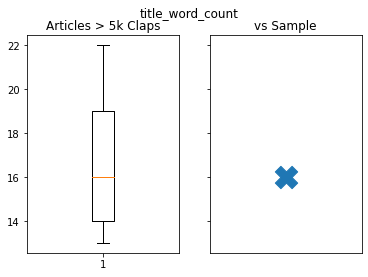

Sample text_word_count is 10.8% Percentile Of Reference Hi Claps Dataset


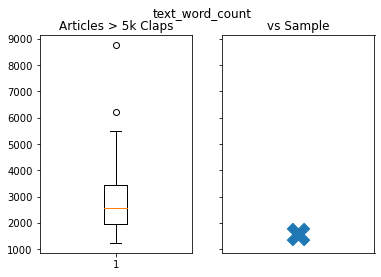

Sample vocab_count_excl_commonwords is 13.5% Percentile Of Reference Hi Claps Dataset


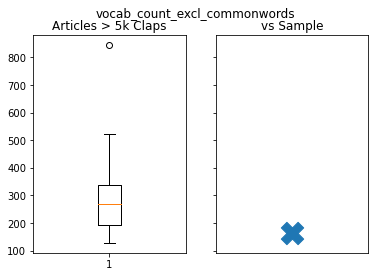

Sample sentence_count is Below The Min Of Reference Hi Claps Dataset !


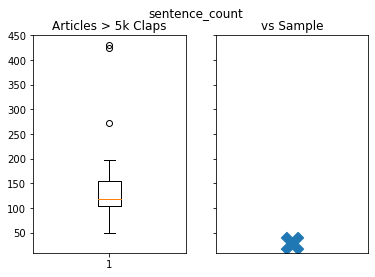

Sample average_word_count_per_sentence Exceeds The Max Of Reference Hi Claps Dataset !


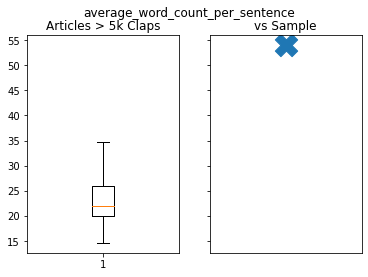

Sample FS_GradeScore is 5.4% Percentile Of Reference Hi Claps Dataset


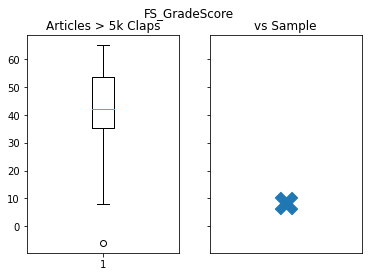

Sample imgs_per_1000words is Below The Min Of Reference Hi Claps Dataset !


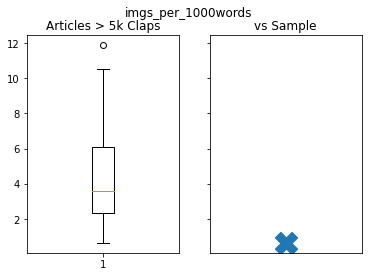

Sample vids_per_1000words is Below The Min Of Reference Hi Claps Dataset !


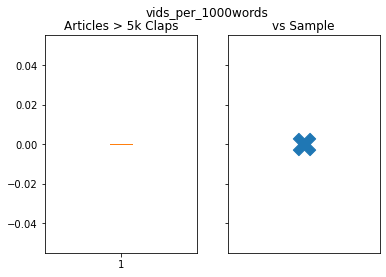

Sample polarity is 29.7% Percentile Of Reference Hi Claps Dataset


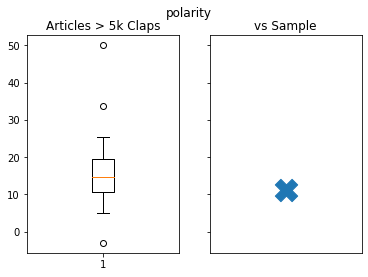

Sample subjectivity is 59.5% Percentile Of Reference Hi Claps Dataset


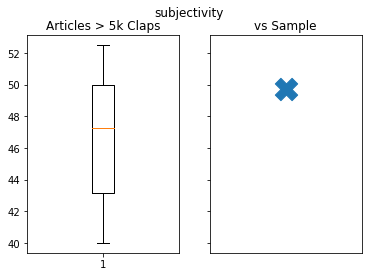

In [16]:
compare_against_refdata(SampleSummary)

Myers-Briggs Type Indicator: ESTJ

Introversion - Extroversion : 0.382 - 0.618
Intuiting - Sensing         : 0.207 - 0.793
Thinking - Feeling          : 0.890 - 0.110
Judging - Perceiving        : 0.562 - 0.438


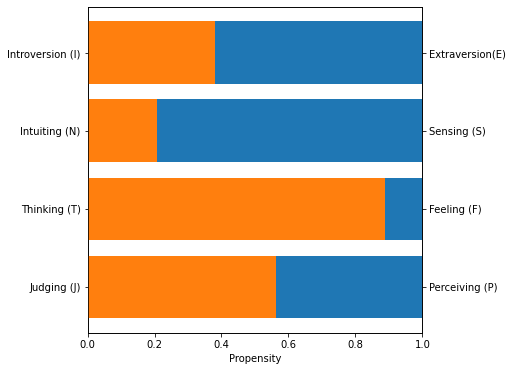

In [17]:
TestArticle.plot_MTBI()

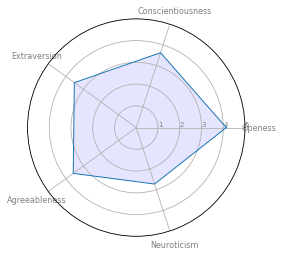

In [18]:
TestArticle.plot_OCEAN_Radar()

Plot Of  TextBlob_Polarity  By Sentence
The X-Axis represents sentences within the document


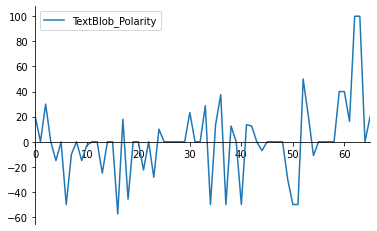

In [19]:
TestArticle.plot_sentence_by_sentence()

In [20]:
AnotherTestArticle=ArticleExtract('https://medium.com/analytics-vidhya/building-a-decision-support-tool-for-capital-budgeting-with-python-pulp-f56785f6668e')
AnotherSampleSummary=AnotherTestArticle.summary()

In [21]:
#Comparing 2 Diff Web Pages


def Side_By_Side_Comparison(SampleOne,SampleTwo):
    SideBySideComparison=pd.concat([pd.DataFrame.from_dict(SampleOne,orient='index'), pd.DataFrame.from_dict(SampleTwo,orient='index')], axis=1)
    SideBySideComparison.columns=["",""]
    return SideBySideComparison

def Compare_Similarity(FirstArticle,SecondArticle=""):
    vecSampleOne = Doc2VecModel.infer_vector(FirstArticle.cleaned_text.split())
    
    if SecondArticle!="":
        vecSampleTwo = Doc2VecModel.infer_vector(SecondArticle.cleaned_text.split())
    elif SecondArticle=="":
        vecSampleTwo = More_Than_5k_Claps_Vector
        
    similarity = (1-spatial.distance.cosine(vecSampleOne, vecSampleTwo))*100
    return similarity

In [22]:
from pandas import option_context
with option_context('display.max_colwidth', 400):
    display(Side_By_Side_Comparison(SampleSummary,AnotherSampleSummary))

,,
Analysis Type,Extracted Web-Page,Extracted Web-Page
title,"Interesting Python Tips and Tricks | by Ravi | Analytics Vidhya | Sep, 2020 | Medium","Building A Decision Support Tool For Capital Budgeting With Python Pulp | by Zhijing Eu | Analytics Vidhya | Sep, 2020 | Medium"
pub_date,2020-09-13,2020-09-08
url,https://medium.com/analytics-vidhya/interesting-python-tips-and-tricks-6d033967b5a5,https://medium.com/analytics-vidhya/building-a-decision-support-tool-for-capital-budgeting-with-python-pulp-f56785f6668e
tags,"[Hackathon, Programming, Python, Software Development, Software Engineering, Python Programming]","[Hackathon, Linear Programming, Optimization, Python Programming, Pythonpulp, Capital Budgeting]"
content_summary,"[This text is about..., tuple, print, list, integer]","[This text is about..., Source]"
most_common_trigrams,"[(Alice, Bob, Charlie), (data, science, ecosystem), (science, ecosystem, https), (Data, Science, professionals), (Science, professionals, We)]","[(set, map, lambda), (science, ecosystem, https), (Decision, Support, Tool), (digital, VidhyaFollowAnalytics, Vidhya), (lambda, x, tuple)]"
title_word_count,16,23
text_word_count,1566,2269
vocab_count_excl_commonwords,163,260


In [23]:
print("Article Similarity is",round(Compare_Similarity(TestArticle,AnotherTestArticle),1),"%")
print("NB: Results May Vary Due To Random Sampling of Words During Vectorization")

Article Similarity is 28.1 %
NB: Results May Vary Due To Random Sampling of Words During Vectorization
